In [22]:
import tensorflow as tf
import tensorflow_probability as tfp
from HMC.TrueDistributions import *
from HMC.ChainMakers import *
tf.experimental.numpy.experimental_enable_numpy_behavior()

mvn = MVN(tf.constant([0,0],dtype=tf.float32), tf.constant([[5,1],[0,1]],dtype=tf.float32))

chain_maker = HamiltonianChainMaker(mvn,n=10**4,step_size=.06)

print(chain_maker)




mean:0.0002  covariance:[[5.17884308 0.59528012]
 [0.59528012 1.07031695]]  acceptance rate:0.5990


In [23]:
chain_maker.getOutput()

array([[-1.5694361 , -0.33035275],
       [ 2.3106515 ,  1.0643296 ],
       [-3.4502153 , -2.7735505 ],
       ...,
       [ 0.04133233,  0.7008569 ],
       [ 0.04133233,  0.7008569 ],
       [-0.11149999,  1.9896326 ]], dtype=float32)

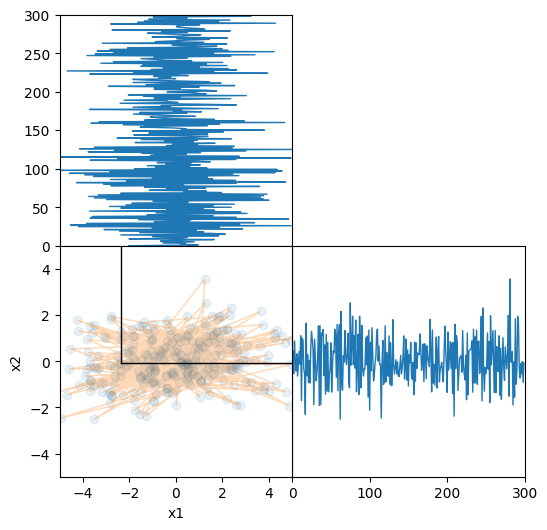

In [12]:
from HMC.ChainVisualizers import visualize
visualize(chain_maker,"hmc.mp4")

In [29]:
import numpy as np
from AM.am import AdaptiveMetropolis

def target_distribution(params):
    mean = np.array([0, 0])
    covariance = np.array([[5, 1], [0, 1]])
    inv_covariance = np.linalg.inv(covariance)
    exponent = -0.5 * np.dot(np.dot((params - mean).T, inv_covariance), (params - mean))
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))
        
# Create an instance of AdaptiveMetropolis
initial_params = [0, 0]
sd = 0.1  # Scaling parameter
epsilon = 1.0  # Parameter for the time-dependent covariance structure
t0 = 100  # Time index for transition in covariance structure
iterations = 10000
am_sampler = AdaptiveMetropolis(target_distribution, initial_params, sd, epsilon, t0, iterations)

am_sampler.getOutput()

array([[ 0.        ,  0.        ],
       [ 0.26023091,  1.10429196],
       [ 0.55834649,  0.65164701],
       ...,
       [ 0.55378556, -0.78398368],
       [ 1.24239211,  0.07192545],
       [ 0.00627579,  0.98214229]])

In [30]:
# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(am_sampler.getOutput(), axis=0)
variance_of_samples = np.cov(np.array(am_sampler.getOutput()).T)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")

Mean of Samples: [-0.00118455  0.04907864]
Variance of Samples: [[4.69564997 0.44623076]
 [0.44623076 1.06459311]]


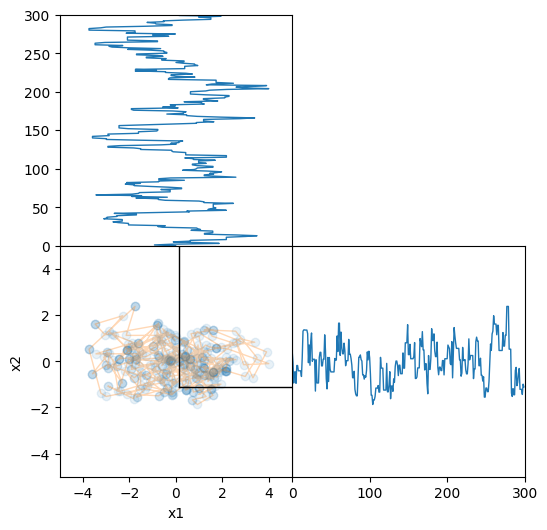

In [8]:
from HMC.ChainVisualizers import visualize
visualize(am_sampler,"adaptive_metropolis.mp4")

In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

In [26]:

# Two-dimensional target distribution function
def target_distribution(x):
    mean = np.array([0, 0])
    covariance = np.array([[5, 1], [0, 1]])
    inv_covariance = np.linalg.inv(covariance)
    exponent = -0.5 * np.dot((x - mean), np.dot(inv_covariance, (x - mean)))
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))


# Proposal distribution for two-dimensional theta
def proposal_distribution(theta, sigma=0.5):
    return theta + np.random.normal(0, sigma, size=theta.shape)

# Function to compute correction factor
def compute_correction_factor(num_points, sigma):
    def objective(C_sigma):
        convolved = np.convolve(stats.norm.cdf(np.linspace(-3*sigma, 3*sigma, num_points)/sigma), C_sigma, mode='same')
        S = 1 / (1 + np.exp(-np.linspace(-3*sigma, 3*sigma, num_points)))
        return np.sum(np.abs(convolved - S))

    initial_guess = np.ones(num_points) / num_points
    result = minimize(objective, initial_guess, method='SLSQP')
    return np.mean(result.x) if result.success else 1.0

# Function to create correction distribution
def create_correction_distribution_function(average_correction_factor, scale=1):
    def correction_distribution():
        return np.random.normal(average_correction_factor, scale)
    return correction_distribution

# Function to compute statistics (Δ*, sample variance, error)
def compute_statistics(current, proposed, minibatch, target_distribution):
    lambda_values = []
    for x in minibatch:
        current_density = target_distribution(current)
        proposed_density = target_distribution(proposed)
        lambda_value = np.log(proposed_density / current_density)
        lambda_values.append(lambda_value)
    lambda_values = np.array(lambda_values)

    delta_star = np.mean(lambda_values)
    sample_variance = np.var(lambda_values)

    # First and third moments for error estimation
    first_moment = np.mean(np.abs(lambda_values - delta_star))
    third_moment = np.mean(np.abs(lambda_values - delta_star)**3)

    # Error estimate
    error = (6.4 * third_moment / np.sqrt(len(minibatch))) + (2 * first_moment / len(minibatch))
    return delta_star, sample_variance, error


# Minibatch acceptance test function
def minibatch_acceptance_test(current, proposed, minibatch, target_distribution, correction_distribution, delta_threshold, error_tolerance):
    global final_minibatch_size
    delta_star, sample_variance, error = compute_statistics(current, proposed, minibatch, target_distribution)
    while sample_variance >= 1 or error > error_tolerance:
        additional_samples = np.random.choice(data, m, replace=False)
        minibatch = np.concatenate((minibatch, additional_samples))
        delta_star, sample_variance, error = compute_statistics(current, proposed, minibatch, target_distribution)
    final_minibatch_size = len(minibatch)
    X_nc = np.random.normal(0, np.sqrt(1 - sample_variance))
    X_corr = correction_distribution()
    return delta_star + X_nc + X_corr > 0

# MCMC sampling with minibatches for two-dimensional theta
def mcmc_with_minibatch(T, m, delta, correction_distribution, initial_sample, proposal_distribution, target_distribution, data):
    samples = [initial_sample]
    theta = initial_sample
    accepted = 0

    for _ in range(T):
        theta_prime = proposal_distribution(theta)
        minibatch_indices = np.random.choice(len(data), m, replace=False)
        minibatch = data[minibatch_indices]

        if minibatch_acceptance_test(theta, theta_prime, minibatch, target_distribution, correction_distribution, 1, delta):
            theta = theta_prime
            accepted += 1
        samples.append(theta)

    acceptance_rate = accepted / T
    print(f"Acceptance Rate: {acceptance_rate}")
    return samples

# Prepare the dataset and parameters
final_minibatch_size = 0
T = 10000  # Reduced number of samples for speed
m = 50   
iters = T
delta = 0.1  # Error bound
average_correction_factor = compute_correction_factor(num_points=100, sigma=0.5)
correction_distribution = create_correction_distribution_function(average_correction_factor)
initial_sample = np.array([0, 0])  # Starting point in the parameter space
data = np.random.normal(0, 1, (1000, 2))  # Simulated dataset

# Run the Metropolis-Hastings algorithm
samples = mcmc_with_minibatch(iters, m, delta, correction_distribution, initial_sample, proposal_distribution, target_distribution, data)


# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(samples, axis=0)
variance_of_samples = np.cov(np.array(samples).T)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")


Acceptance Rate: 0.7028
Mean of Samples: [-0.08852544  0.06050194]
Variance of Samples: [[7.7158435  1.03846885]
 [1.03846885 1.64257278]]


In [27]:
samples

[array([0, 0]),
 array([ 0.1157987 , -0.30676848]),
 array([ 0.35444572, -0.137657  ]),
 array([ 0.35444572, -0.137657  ]),
 array([ 1.00308602, -0.44525596]),
 array([ 0.99025889, -0.14219208]),
 array([ 0.99025889, -0.14219208]),
 array([ 1.85904966, -0.07666144]),
 array([ 2.06813916, -0.15996488]),
 array([1.75529409, 0.66683718]),
 array([1.75529409, 0.66683718]),
 array([2.74833262, 0.25790122]),
 array([2.25460426, 0.19130659]),
 array([ 2.08565576, -0.72652928]),
 array([ 2.08565576, -0.72652928]),
 array([ 2.32723576, -0.66710223]),
 array([ 1.85186553, -1.30394624]),
 array([ 1.85186553, -1.30394624]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.93619353, -0.47699266]),
 array([ 1.70788709, -0.33385384]),
 array([ 1.8024772 , -0.55903673]),
 array([1.52652129, 0.63790081]),
 array([1.23348702, 0.55654849]),
 array([0.32105244, 0.90

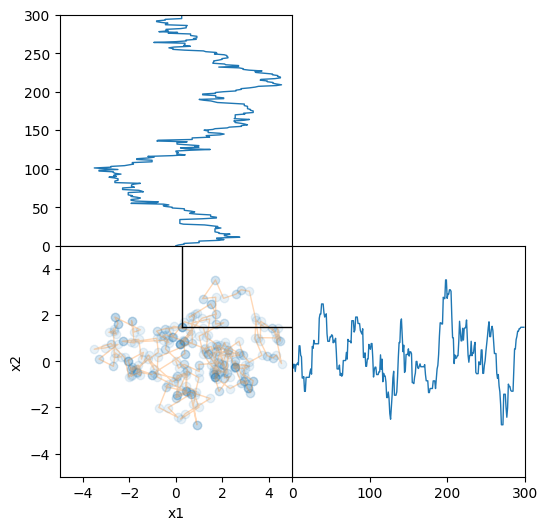

In [28]:
from HMC.ChainVisualizers import visualize

class MiniBatchChain:
    def __init__(self,samples) -> None:
        self.samples = np.array(samples)

    def getOutput(self):
        return self.samples
minibatch_chain = MiniBatchChain(samples)

visualize(minibatch_chain,"minibatch_metropolis.mp4")

Single Sample: [2.47021837 4.45914635]


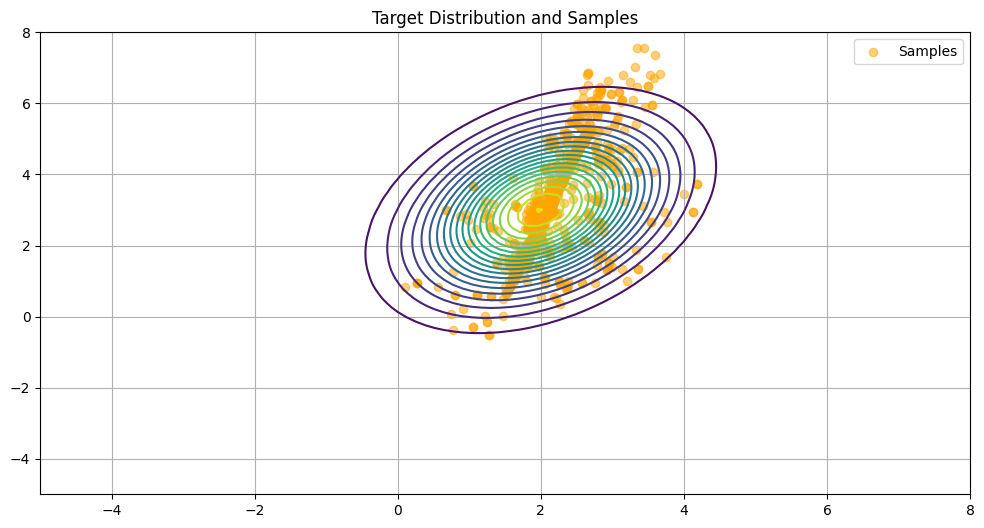

array([[ 0.62931431,  0.04521339],
       [ 1.80433935,  0.33941523],
       [ 0.3281622 , -0.77947478],
       ...,
       [-1.29199555, -0.41532562],
       [-1.44729364, -0.37336227],
       [-1.51569576, -0.3583946 ]])

In [1]:
from dram import DRAM
import numpy as np
def target_distribution(params):
    mean = np.array([0, 0])
    covariance = np.array([[5, 1], [0, 1]])
    inv_covariance = np.linalg.inv(covariance)
    exponent = -0.5 * np.dot(np.dot((params - mean).T, inv_covariance), (params - mean))
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))
        
# Create an instance of DelayedRejectionMCMC
initial_params = [0, 0]
iterations = 10000
t0 = 100
dram_sampler = DRAM(target_distribution, initial_params, iterations, t0)

dram_sampler.getOutput()

In [2]:
# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(dram_sampler.getOutput(), axis=0)
variance_of_samples = np.cov(np.array(dram_sampler.getOutput()).T)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")

Mean of Samples: [-1.23285504 -0.40204817]
Variance of Samples: [[ 2.11103823 -0.14338997]
 [-0.14338997  0.22969485]]


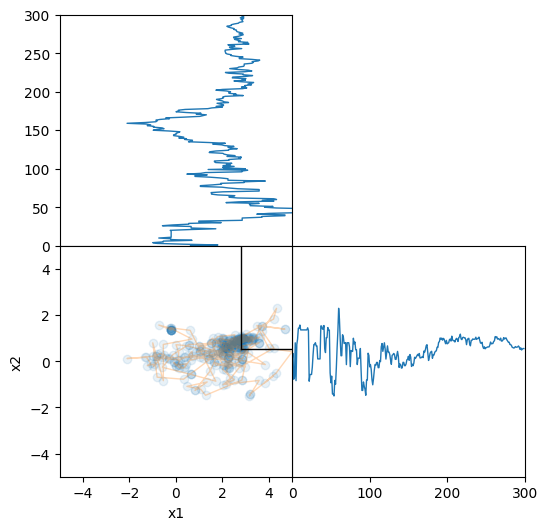

In [3]:
from HMC.ChainVisualizers import visualize
visualize(dram_sampler,"dram.mp4")